In [1]:
import math
from dataclasses import dataclass
from typing import Dict, List, Optional, Union

import matplotlib
import matplotlib.pyplot as plt

import numpy as np


def cv_to_alpha(cv: float, num_permuntations: int) -> float:
    alpha = ((num_permuntations - 1) / (cv * cv) - 1.0) / (num_permuntations * 1.0)
    assert (
        alpha > 0.0
    ), "with the given CV and number of permutations, alpha is not positive."
    return alpha


def random_permutation_generator(
    num_elements: int,
    num_permutations: int,
) -> List[List[int]]:
    output = [
        np.random.permutation(num_elements).tolist() for _ in range(num_permutations)
    ]
    assert len(output) == num_permutations
    for permutation in output:
        assert len(permutation) == num_elements
    return output


def calculate_positional_permutation(permutation: List[int]) -> List[int]:
    num_elements = len(permutation)
    return [permutation.index(i) for i in range(num_elements)]

# Choice Model

In [2]:
@dataclass
class ExperimentParameters:
    num_elements: int = 8
    num_frequent_permutations: int = 5
    num_rare_permutations: int = 20
    rho: float = 0.01
    cv: float = 0.1
    num_layers_with_element_in_dag: int = 3
    kappa: float = 0.01
    delta: float = 0.05
    eps: float  = 0.001


class ChoiceModel:
    def __init__(
        self,
        experiment_parameters: ExperimentParameters,
    ):
        self.num_elements = experiment_parameters.num_elements
        ## Frequent
        self.num_frequent_permutations = experiment_parameters.num_frequent_permutations
        (
            self.permutations,
            self.positional_permutations,
            self.distribution,
        ) = self._generate_choice_model(
            num_elements=self.num_elements,
            num_permutations=experiment_parameters.num_frequent_permutations,
            cv=experiment_parameters.cv,
            multiplier=1.0 - experiment_parameters.rho,
        )
        assert isinstance(self.permutations, list)
        assert isinstance(self.positional_permutations, list)
        assert isinstance(self.distribution, np.ndarray)
        ## Rare
        rare_data = self._generate_choice_model(
            num_elements=self.num_elements,
            num_permutations=experiment_parameters.num_rare_permutations,
            cv=experiment_parameters.cv,
            multiplier=experiment_parameters.rho,
        )
        assert isinstance(rare_data[0], list)
        assert isinstance(rare_data[1], list)
        assert isinstance(rare_data[2], np.ndarray)
        self.permutations += rare_data[0]
        self.positional_permutations += rare_data[1]
        self.distribution = np.concatenate((self.distribution, rare_data[2]))
        ## Others
        self.total_queries = 0
        self.num_layers_with_element_in_dag = (
            experiment_parameters.num_layers_with_element_in_dag
        )

    def print(self):
        print(f"num_elements: {self.num_elements}")
        for permutation, density in zip(self.permutations, self.distribution):
            print(permutation, density)

    def calculate_assortment(
        self, prefixes_to_exclude_the_union_of: List[List[int]] = []
    ) -> List[int]:
        num_prefixes = len(prefixes_to_exclude_the_union_of)
        counter = [0 for _ in range(self.num_elements)]
        for prefix in prefixes_to_exclude_the_union_of:
            for item in prefix:
                counter[item] += 1
        output = []
        for i in range(self.num_elements):
            if counter[i] < num_prefixes:
                output.append(i)
        return output

    # def naively_calculate_density(
    #     self, offered_set: List[int], target_item: int, num_samples: int
    # ) -> float:
    #     assert target_item in offered_set
    #     self.total_queries += num_samples
    #     positional_permuatations = self._draw_positional_permutations(num_samples)
    #     output = 0
    #     for positional_permutation in positional_permuatations:
    #         winner_index = min([positional_permutation[item] for item in offered_set])
    #         if winner_index == positional_permutation[target_item]:
    #             output += 1
    #     return (output * 1.0) / num_samples

    def calculate_density_ground_truth(
        self, offered_set: List[int], target_item: int
    ) -> float:
        assert target_item in offered_set, f"{offered_set}, {target_item}"
        p = 0.0
        for positional_permutation, density in zip(
            self.positional_permutations, self.distribution
        ):
            if (
                min([positional_permutation[item] for item in offered_set])
                == positional_permutation[target_item]
            ):
                p += density
        return p

    def calculate_density_ground_truth_vector(
        self, offered_set: List[int]
    ) -> List[float]:
        p = [0.0 for _ in offered_set]
        for positional_permutation, density in zip(
            self.positional_permutations, self.distribution
        ):
            winner_index = np.argmin([positional_permutation[item] for item in offered_set])
            p[winner_index] += density
        assert sum(p) > 0.999 and sum(p) < 1.001
        return p
    
    def estimate_density(
        self, offered_set: List[int], target_item: int, num_samples: int
    ) -> float:
        assert target_item in offered_set, f"{offered_set}, {target_item}"
        self.total_queries += num_samples
        p = self.calculate_density_ground_truth(
            offered_set=offered_set, target_item=target_item
        )
        return np.random.binomial(n=num_samples, p=p) / num_samples

    def calculate_market_share_ground_truth(
        self, offered_set: List[int], frequents_only: bool = False
    ) -> float:
        output = 0.0
        num_permutations = (
            self.num_frequent_permutations
            if frequents_only
            else len(self.positional_permutations)
        )
        for positional_permutation, density in zip(
            self.positional_permutations[:num_permutations],
            self.distribution[:num_permutations],
        ):
            if (
                min([positional_permutation[item] for item in offered_set])
                < self.num_layers_with_element_in_dag
            ):
                output += density
        return output

    @staticmethod
    def _generate_choice_model(
        num_elements: int, num_permutations: int, cv: float, multiplier: float
    ) -> (List[List[int]], List[List[int]], np.ndarray):
        permutations = random_permutation_generator(
            num_elements=num_elements,
            num_permutations=num_permutations,
        )
        positional_permutations = [
            calculate_positional_permutation(permutation)
            for permutation in permutations
        ]
        alpha = cv_to_alpha(cv=cv, num_permuntations=num_permutations)
        alpha_list = [alpha for _ in range(num_permutations)]
        distribution = np.random.dirichlet(alpha_list) * multiplier
        return (permutations, positional_permutations, distribution)

    # def _draw_positional_permutations(self, num_samples: int) -> List[List[int]]:
    #     samples = np.random.choice(
    #         a=len(self.positional_permutations),
    #         size=num_samples,
    #         p=self.distribution,
    #     )
    #     assert len(samples) == num_samples
    #     return [self.positional_permutations[i] for i in samples]

# Model Calculator

In [3]:
class DagNode:
    def __init__(self, items: List[int] = [], node_density: float = 0.0):
        self.items: List[int] = items
        self.node_density: float = node_density
        self.edges: List[int] = []
        self.edge_densities: List[float] = []


class ModelEstimator:
    def __init__(
        self,
        choice_model: ChoiceModel,
        experiment_parameters: ExperimentParameters,
    ):
        self.choice_model = choice_model
        self.num_elements = experiment_parameters.num_elements
        self.num_layers_with_element_in_dag = (
            experiment_parameters.num_layers_with_element_in_dag
        )
        assert self.num_elements >= self.num_layers_with_element_in_dag
        self.kappa = experiment_parameters.kappa
        self.eps = min(
            1.0 * experiment_parameters.eps / self.num_layers_with_element_in_dag,
            self.kappa / 4.0,
        )
        self.delta = experiment_parameters.delta / (
            1.0
            * self.num_elements
            * self.num_layers_with_element_in_dag
            * experiment_parameters.num_frequent_permutations
        )
        self.layers = []

    def solve(self):
        self.layers = [[DagNode(node_density=1.0)]]
        for i in range(self.num_layers_with_element_in_dag):
            if len(self.layers[i]) == 0:
                break
            self.layers.append([])
            self._solve_layer(i)

    def print(self):
        for i, layer in enumerate(self.layers):
            print(f"Layer {i}:")
            for j, node in enumerate(layer):
                print(
                    f"Node {j}:",
                    node.items,
                    node.node_density,
                    node.edges,
                    node.edge_densities,
                )
            print()
        print("total queries:", self.choice_model.total_queries)

    def estimate_density_from_dag(
        self, offered_set_excluding_target: List[int], target_item: int
    ) -> float:
        assert target_item not in offered_set_excluding_target
        output = 0.0
        for layer in self.layers:
            for node in layer:
                for (edge, density) in zip(node.edges, node.edge_densities):
                    if edge == target_item:
                        if all(
                            item not in node.items
                            for item in offered_set_excluding_target
                        ):
                            output += density
                        break  # ending this note
        return output

    def estimate_density_from_dag_vector(self, offered_set: List[int]) -> List[float]:
        return [
            self.estimate_density_from_dag(
                offered_set_excluding_target=(
                    offered_set[:i].tolist() + offered_set[i + 1 :].tolist()
                ),
                target_item=offered_set[i],
            )
            for i in range(len(offered_set))
        ]

    def estimate_market_share_from_dag(self, offered_set: List[int]) -> float:
        output = 0.0
        for node in self.layers[-1]:
            if any(item in node.items for item in offered_set):
                output += node.node_density
        return output

    def _solve_layer(self, layer_index: int):
        for node_index in range(len(self.layers[layer_index])):
            self._solve_node(layer_index, node_index)

    def _solve_node(self, layer_index: int, node_index: int):
        for target_item in range(self.num_elements):
            if target_item not in self.layers[layer_index][node_index].items:
                self._solve_edge(layer_index, node_index, target_item)

    def _solve_edge(self, layer_index: int, node_index: int, target_item: int):
        current_items = self.layers[layer_index][node_index].items
        assert layer_index == len(current_items)
        assert target_item not in current_items
        offered_set = self.choice_model.calculate_assortment(
            prefixes_to_exclude_the_union_of=[current_items]
        )
        raw_density = self.choice_model.estimate_density(
            offered_set=offered_set,
            target_item=target_item,
            num_samples=self._sample_size_calculator(set_cover_size=len(current_items)),
        )
        covering_sets = [
            current_items[:i] + current_items[i + 1 :]
            for i in range(len(current_items))
        ]
        num_covering_sets = len(covering_sets)
        assert num_covering_sets == len(current_items)
        covered_sets = []
        for i in range(layer_index):
            for node in self.layers[i]:
                if target_item in node.edges and all(
                    item in current_items for item in node.items
                ):
                    covered_sets.append(node.items)
        num_covered_sets = len(covered_sets)
        covering_vectors = [
            [0 for _ in range(num_covered_sets)] for _ in range(num_covering_sets)
        ]
        is_covered_at_least_once = [False for _ in range(num_covered_sets)]
        for i in range(num_covering_sets):
            for j in range(num_covered_sets):
                if all(item in covering_sets[i] for item in covered_sets[j]):
                    covering_vectors[i][j] = 1
                    is_covered_at_least_once[j] = True
        assert all(is_covered_at_least_once)
        if num_covering_sets == 0:
            final_density = raw_density
        else:
            set_cover = self._greedy_set_cover(covering_sets, covering_vectors)
            double_counting = self._inclusion_exclusion_recursion(
                set_cover=set_cover,
                target_item=target_item,
            )
            # assert double_counting >= 0.0, double_counting
            final_density = raw_density - double_counting
        if final_density < self.kappa / 2.0:
            return
        self.layers[layer_index][node_index].edges.append(target_item)
        self.layers[layer_index][node_index].edge_densities.append(final_density)
        new_items = self.layers[layer_index][node_index].items + [target_item]
        new_node_index = self._find_or_insert_node_in_layer(layer_index + 1, new_items)
        self.layers[layer_index + 1][new_node_index].node_density += final_density

    def _find_or_insert_node_in_layer(self, layer_index: int, items: List[int]) -> int:
        for node_index in range(len(self.layers[layer_index])):
            if all(
                item in self.layers[layer_index][node_index].items for item in items
            ):
                return node_index
        self.layers[layer_index].append(DagNode(items=items))
        return len(self.layers[layer_index]) - 1

    def _greedy_set_cover(
        self,
        covering_sets: List[List[int]],
        covering_vectors: List[List[Union[int, bool]]],
    ) -> List[List[int]]:
        num_covering_sets = len(covering_vectors)
        assert num_covering_sets > 0
        num_covered_sets = len(covering_vectors[0])
        for covering_vector in covering_vectors:
            assert len(covering_vector) == num_covered_sets
        output = []
        while True:
            current_sum = [sum(covering_vector) for covering_vector in covering_vectors]
            max_index = np.argmax(current_sum)
            if current_sum[max_index] == 0:
                break
            output.append(covering_sets[max_index])
            for i in range(num_covered_sets):
                if covering_vectors[max_index][i] == 1:
                    for j in range(num_covering_sets):
                        covering_vectors[j][i] = 0
        return output

    def _inclusion_exclusion_recursion(
        self,
        set_cover: List[List[int]],
        target_item: int,
        set_cover_size: Optional[int] = None,
        power_of_two_factor: Optional[int] = None,
        current_index: int = 0,
        prefixes_to_exclude: List[List[int]] = [],
    ) -> float:
        if set_cover_size is None:
            set_cover_size = len(set_cover)
        if power_of_two_factor is None:
            power_of_two_factor = pow(2, 2 * set_cover_size - 1)
        if current_index == set_cover_size:
            if len(prefixes_to_exclude) == 0:
                return 0.0
            offered_set = self.choice_model.calculate_assortment(
                prefixes_to_exclude_the_union_of=prefixes_to_exclude
            )
            num_samples = self._sample_size_calculator(
                set_cover_size=set_cover_size, power_of_two_factor=power_of_two_factor
            )
            output = self.choice_model.estimate_density(
                offered_set=offered_set,
                target_item=target_item,
                num_samples=num_samples,
            )
            return output if len(prefixes_to_exclude) % 2 == 1 else -output
        ## current_index < set_cover_size
        output = self._inclusion_exclusion_recursion(
            set_cover=set_cover,
            target_item=target_item,
            set_cover_size=set_cover_size,
            power_of_two_factor=power_of_two_factor,
            current_index=current_index + 1,
            prefixes_to_exclude=prefixes_to_exclude,
        )
        prefixes_to_exclude.append(set_cover[current_index])
        output += self._inclusion_exclusion_recursion(
            set_cover=set_cover,
            target_item=target_item,
            set_cover_size=set_cover_size,
            power_of_two_factor=power_of_two_factor,
            current_index=current_index + 1,
            prefixes_to_exclude=prefixes_to_exclude,
        )
        prefixes_to_exclude.pop()
        return output

    def _sample_size_calculator(
        self, set_cover_size: int, power_of_two_factor: Optional[int] = None
    ) -> int:
        if power_of_two_factor is None:
            power_of_two_factor = pow(2, 2 * set_cover_size - 1)
        return int(
            power_of_two_factor
            * (math.log(1.0 / self.delta) + (set_cover_size + 1) * math.log(2.0))
            / (self.eps * self.eps)
            + 1.0
        )

# Data Analyzer

In [4]:
class DataAnalyzer:
    def __init__(
        self,
        experiment_parameters: ExperimentParameters,
        set_size_to_analyze: int,
        num_runs: int,
        calculate_quantile: bool = False,
    ):
        self.experiment_parameters = experiment_parameters
        self.num_elements = experiment_parameters.num_elements
        self.set_size_to_analyze = set_size_to_analyze
        assert self.num_elements > self.set_size_to_analyze
        self.num_runs = num_runs
        self.calculate_quantile = calculate_quantile
        self.measurement = {}

    def __call__(self) -> Dict[str, float]:
        for _ in range(self.num_runs):
            self._run()
        return self._summarize()

    def _run(self):
        offered_set = np.random.choice(
            self.num_elements,
            p=[1.0 / self.num_elements for _ in range(self.num_elements)],
            size=self.set_size_to_analyze,
            replace=False,
        )
        choice_model = ChoiceModel(experiment_parameters=self.experiment_parameters)
        model_estimator = ModelEstimator(
            choice_model=choice_model,
            experiment_parameters=self.experiment_parameters,
        )
        model_estimator.solve()
        self._update_measurement(
            choice_model=choice_model,
            model_estimator=model_estimator,
            offered_set=offered_set,
        )

    def _update_measurement(
        self,
        choice_model: ChoiceModel,
        model_estimator: ModelEstimator,
        offered_set: list,
    ) -> None:
        raise NotImplementedError("has to be implemented in the sub-class.")

    def _summarize(self):
        for label in self.measurement:
            if not self.calculate_quantile:
                self.measurement[label] /= self.num_runs * 1.0
            else:
                temp = np.array(self.measurement[label])
                self.measurement[label] = (
                    f"mean: {np.mean(temp)}, "
                    + f"std (unnormalized): {np.std(temp)}, "
                    + f"25%: {np.quantile(temp, 0.25)}, "
                    + f"50%: {np.quantile(temp, 0.50)}, "
                    + f"75%: {np.quantile(temp, 0.75)}, "
                    + f"90%: {np.quantile(temp, 0.90)}"
                )
        return self.measurement

## Item Density

In [5]:
class DataAnalyzerItemDensity(DataAnalyzer):
    def __init__(
        self,
        experiment_parameters: ExperimentParameters,
        set_size_to_analyze: int,
        num_runs: int,
    ):
        super().__init__(
            experiment_parameters=experiment_parameters,
            set_size_to_analyze=set_size_to_analyze,
            num_runs=num_runs,
        )
        self.measurement["num_queries"] = 0.0
        self.measurement["market_share"] = 0.0
        self.measurement["density_ground_truth"] = 0.0
        self.measurement["density_estimation"] = 0.0
        self.measurement["density_absolute_error"] = 0.0
        # self.measurement["density_relative_error"] = 0.0

    def _update_measurement(
        self,
        choice_model: ChoiceModel,
        model_estimator: ModelEstimator,
        offered_set: list,
    ) -> None:
        self.measurement["num_queries"] += choice_model.total_queries
        assert len(offered_set) > 0
        target_item = offered_set[0]
        density_ground_truth = choice_model.calculate_density_ground_truth(
            offered_set=offered_set, target_item=target_item
        )
        density_estimation = model_estimator.estimate_density_from_dag(
            offered_set_excluding_target=offered_set[1:], target_item=target_item
        )
        self.measurement[
            "market_share"
        ] += choice_model.calculate_market_share_ground_truth(offered_set=offered_set)
        self.measurement["density_ground_truth"] += density_ground_truth
        self.measurement["density_estimation"] += density_estimation
        self.measurement["density_absolute_error"] += abs(
            density_ground_truth - density_estimation
        )
        # self.measurement["density_relative_error"] += abs(
        #     (density_ground_truth - density_estimation) / density_ground_truth - 1.0
        # )

In [6]:
experiment_parameters = ExperimentParameters(
    num_elements=16,
    num_layers_with_element_in_dag=6,
)

data_analyzer = DataAnalyzerItemDensity(
    experiment_parameters=experiment_parameters,
    set_size_to_analyze=4,
    num_runs=100
)

print(data_analyzer())

{'num_queries': 18235996629112.58, 'market_share': 0.8722195824250669, 'density_ground_truth': 0.2635577498711836, 'density_estimation': 0.23117477127792474, 'density_absolute_error': 0.03239168034037564}


### Experimentation with rho

In [7]:
if False:
    _RHO_LIST_ = [
        0.005,
        0.01,
        0.015,
        0.02,
        0.025,
        0.03,
        0.035,
        0.04,
        0.045,
        0.05,
    ]
    _SET_SIZE_TO_ANALYZE_LIST_ = [2, 3, 4, 5]
    _NUM_RUNS_ = 1000
    _DEFAULT_SETTING_: Dict[str, Union[float, int]] = {
        # "num_elements": 8,
        # "num_frequent_permutations": 5,
        # "num_rare_permutations": 20,
        # "rho": 0.01,
        "num_layers_with_element_in_dag": 3,
        # "kappa": 0.01,
        # "delta": 0.05,
        # "eps": 0.01
    }

    results = {}

    def run_for_set_size_to_analyze(set_size_to_analyze: int) -> None:
        results[set_size_to_analyze] = []
        for rho in _RHO_LIST_:
            _DEFAULT_SETTING_["rho"] = rho
            experiment_parameters = ExperimentParameters(**_DEFAULT_SETTING_)
            data_analyzer = DataAnalyzerItemDensity(
                experiment_parameters=experiment_parameters,
                set_size_to_analyze=set_size_to_analyze,
                num_runs=_NUM_RUNS_,
            )
            results[set_size_to_analyze].append(
                data_analyzer()["density_absolute_error"]
            )

    for set_size_to_analyze in _SET_SIZE_TO_ANALYZE_LIST_:
        run_for_set_size_to_analyze(set_size_to_analyze=set_size_to_analyze)
        plt.plot(
            _RHO_LIST_,
            results[set_size_to_analyze],
            label=f"sets of size {set_size_to_analyze}",
        )

    plt.legend()
    plt.xlabel("rho")
    plt.ylabel("Density Absolute Error")
    plt.show()

In [8]:
if False:
    _RHO_LIST_ = [
        0.005,
        0.01,
        0.015,
        0.02,
        0.025,
        0.03,
        0.035,
        0.04,
        0.045,
        0.05,
    ]
    _SET_SIZE_TO_ANALYZE_LIST_ = [2, 3, 4, 5]
    _NUM_RUNS_ = 1000
    _DEFAULT_SETTING_: Dict[str, Union[float, int]] = {
        # "num_elements": 8,
        # "num_frequent_permutations": 5,
        # "num_rare_permutations": 20,
        # "rho": 0.01,
        "num_layers_with_element_in_dag": 5,
        # "kappa": 0.01,
        # "delta": 0.05,
        # "eps": 0.01
    }

    results = {}

    def run_for_set_size_to_analyze(set_size_to_analyze: int) -> None:
        results[set_size_to_analyze] = []
        for rho in _RHO_LIST_:
            _DEFAULT_SETTING_["rho"] = rho
            # pyre-ignore
            experiment_parameters = ExperimentParameters(**_DEFAULT_SETTING_)
            data_analyzer = DataAnalyzerItemDensity(
                experiment_parameters=experiment_parameters,
                set_size_to_analyze=set_size_to_analyze,
                num_runs=_NUM_RUNS_,
            )
            results[set_size_to_analyze].append(
                data_analyzer()["density_absolute_error"]
            )

    for set_size_to_analyze in _SET_SIZE_TO_ANALYZE_LIST_:
        run_for_set_size_to_analyze(set_size_to_analyze=set_size_to_analyze)
        plt.plot(
            _RHO_LIST_,
            results[set_size_to_analyze],
            label=f"sets of size {set_size_to_analyze}",
        )

    plt.legend()
    plt.xlabel("rho")
    plt.ylabel("Density Absolute Error")
    plt.show()

### Experiments with epsilon

In [9]:
if False:
    _EPS_LIST_ = [
        0.005,
        0.01,
        0.015,
        0.02,
        0.025,
        0.03,
        0.035,
        0.04,
        0.045,
        0.05,
    ]
    _SET_SIZE_TO_ANALYZE_LIST_ = [2, 3, 4, 5]
    _NUM_RUNS_ = 100
    _DEFAULT_SETTING_: Dict[str, Union[float, int]] = {
        # "num_elements": 8,
        # "num_frequent_permutations": 5,
        # "num_rare_permutations": 20,
        # "rho": 0.01,
        "num_layers_with_element_in_dag": 3,
        # "kappa": 0.01,
        # "delta": 0.05,
        # "eps": 0.01
    }

    results = {}

    def run_for_set_size_to_analyze(set_size_to_analyze: int) -> None:
        results[set_size_to_analyze] = []
        for eps in _EPS_LIST_:
            _DEFAULT_SETTING_["eps"] = eps
            # pyre-ignore
            experiment_parameters = ExperimentParameters(**_DEFAULT_SETTING_)
            data_analyzer = DataAnalyzerItemDensity(
                experiment_parameters=experiment_parameters,
                set_size_to_analyze=set_size_to_analyze,
                num_runs=_NUM_RUNS_,
            )
            results[set_size_to_analyze].append(
                data_analyzer()["density_absolute_error"]
            )

    for set_size_to_analyze in _SET_SIZE_TO_ANALYZE_LIST_:
        run_for_set_size_to_analyze(set_size_to_analyze=set_size_to_analyze)
        plt.plot(
            _EPS_LIST_,
            results[set_size_to_analyze],
            label=f"sets of size {set_size_to_analyze}",
        )

    plt.legend()
    plt.xlabel("eps")
    plt.ylabel("Density Absolute Error")
    plt.show()

In [10]:
if False:
    _EPS_LIST_ = [
        0.005,
        0.01,
        0.015,
        0.02,
        0.025,
        0.03,
        0.035,
        0.04,
        0.045,
        0.05,
    ]
    _SET_SIZE_TO_ANALYZE_LIST_ = [2, 3, 4, 5]
    _NUM_RUNS_ = 100
    _DEFAULT_SETTING_: Dict[str, Union[float, int]] = {
        # "num_elements": 8,
        # "num_frequent_permutations": 5,
        # "num_rare_permutations": 20,
        # "rho": 0.01,
        "num_layers_with_element_in_dag": 5,
        # "kappa": 0.01,
        # "delta": 0.05,
        # "eps": 0.01
    }

    results = {}

    def run_for_set_size_to_analyze(set_size_to_analyze: int) -> None:
        results[set_size_to_analyze] = []
        for eps in _EPS_LIST_:
            _DEFAULT_SETTING_["eps"] = eps
            # pyre-ignore
            experiment_parameters = ExperimentParameters(**_DEFAULT_SETTING_)
            data_analyzer = DataAnalyzerItemDensity(
                experiment_parameters=experiment_parameters,
                set_size_to_analyze=set_size_to_analyze,
                num_runs=_NUM_RUNS_,
            )
            results[set_size_to_analyze].append(
                data_analyzer()["density_absolute_error"]
            )

    for set_size_to_analyze in _SET_SIZE_TO_ANALYZE_LIST_:
        run_for_set_size_to_analyze(set_size_to_analyze=set_size_to_analyze)
        plt.plot(
            _EPS_LIST_,
            results[set_size_to_analyze],
            label=f"sets of size {set_size_to_analyze}",
        )

    plt.legend()
    plt.xlabel("eps")
    plt.ylabel("Density Absolute Error")
    plt.show()

## Table View of Density Estimation

In [11]:
def L1_distance(first: List[float], second: List[float]) -> float:
    return sum(abs(x - y) for x, y in zip(first, second))


class DataAnalyzerSetDensity(DataAnalyzer):
    def __init__(
        self,
        experiment_parameters: ExperimentParameters,
        set_size_to_analyze: int,
        num_runs: int,
    ):
        super().__init__(
            experiment_parameters=experiment_parameters,
            set_size_to_analyze=set_size_to_analyze,
            num_runs=num_runs,
            calculate_quantile=True,
        )
        self.measurement["total_queries"] = []
        self.measurement["l1_error"] = []

    def _update_measurement(
        self,
        choice_model: ChoiceModel,
        model_estimator: ModelEstimator,
        offered_set: list,
    ) -> None:
        self.measurement["total_queries"].append(choice_model.total_queries)
        assert len(offered_set) > 0
        density_ground_truth_vector = (
            choice_model.calculate_density_ground_truth_vector(offered_set=offered_set)
        )
        density_estimation_vector = model_estimator.estimate_density_from_dag_vector(
            offered_set=offered_set
        )
        self.measurement["l1_error"].append(
            L1_distance(density_ground_truth_vector, density_estimation_vector)
        )

In [12]:
if False:
    _SET_SIZE_TO_ANALYZE_ = 3

    for num_elements in [8, 16, 32]:
        for num_layers_with_element_in_dag_base in [3, 4, 5]:
            num_layers_with_element_in_dag = num_layers_with_element_in_dag_base * (num_elements // 8)
            for rho in [0.005, 0.01, 0.02]:
                for eps in [0.005, 0.01, 0.02]:
                    experiment_parameters = ExperimentParameters(
                        num_elements=num_elements,
                        rho=rho,
                        num_layers_with_element_in_dag=num_layers_with_element_in_dag,
                        eps=eps,
                    )
                    data_analyzer = DataAnalyzerSetDensity(
                        experiment_parameters=experiment_parameters,
                        set_size_to_analyze=_SET_SIZE_TO_ANALYZE_,
                        num_runs=100,
                    )
                    print(f"num_elements = {num_elements}, num_layers_with_element_in_dag = {num_layers_with_element_in_dag}, rho = {rho}, eps = {eps}.")
                    print(data_analyzer())
                    print()

In [13]:
if False:
    _SET_SIZE_TO_ANALYZE_ = 5

    for num_elements in [8, 16, 32]:
        for num_layers_with_element_in_dag_base in [3, 4, 5]:
            num_layers_with_element_in_dag = num_layers_with_element_in_dag_base * (
                num_elements // 8
            )
            for rho in [0.005, 0.01, 0.02]:
                for eps in [0.005, 0.01, 0.02]:
                    experiment_parameters = ExperimentParameters(
                        num_elements=num_elements,
                        rho=rho,
                        num_layers_with_element_in_dag=num_layers_with_element_in_dag,
                        eps=eps,
                    )
                    data_analyzer = DataAnalyzerSetDensity(
                        experiment_parameters=experiment_parameters,
                        set_size_to_analyze=_SET_SIZE_TO_ANALYZE_,
                        num_runs=100,
                    )
                    print(
                        f"num_elements = {num_elements}, num_layers_with_element_in_dag = {num_layers_with_element_in_dag}, rho = {rho}, eps = {eps}."
                    )
                    print(data_analyzer())
                    print()

## Table View of Density Estimation; Nested Loop

In [14]:
class DataAnalyzerDensityNestedLoop(DataAnalyzer):
    def __init__(
        self,
        experiment_parameters: ExperimentParameters,
        set_size_to_analyze: int,
        num_runs: int,
        num_runs_per_choice_model: int,
    ):
        super().__init__(
            experiment_parameters=experiment_parameters,
            set_size_to_analyze=set_size_to_analyze,
            num_runs=num_runs,
            calculate_quantile=True,
        )
        self.num_runs_per_choice_model = num_runs_per_choice_model
        self.measurement["l1_error_of_choice_model"] = []

    def _run(self):
        choice_model = ChoiceModel(experiment_parameters=self.experiment_parameters)
        result = 0.0
        for _ in range(self.num_runs_per_choice_model):
            offered_set = np.random.choice(
                self.num_elements,
                p=[1.0 / self.num_elements for _ in range(self.num_elements)],
                size=self.set_size_to_analyze,
                replace=False,
            )
            model_estimator = ModelEstimator(
                choice_model=choice_model,
                experiment_parameters=self.experiment_parameters,
            )
            model_estimator.solve()
            density_ground_truth_vector = (
                choice_model.calculate_density_ground_truth_vector(offered_set=offered_set)
            )
            density_estimation_vector = model_estimator.estimate_density_from_dag_vector(
                offered_set=offered_set
            )
            result += L1_distance(density_ground_truth_vector, density_estimation_vector)
        self._update_measurement(1.0 * result / self.num_runs_per_choice_model)

    def _update_measurement(self, l1_error_of_choice_model: float):
        self.measurement["l1_error_of_choice_model"].append(l1_error_of_choice_model)

In [15]:
if False:
    _SET_SIZE_TO_ANALYZE_ = 3

    scenario_counter = 0
    _NUM_SCENARIO_TO_SKIP_ = 0

    for num_elements in [8, 16]:
        for num_layers_with_element_in_dag_base in [3, 4, 5]:
            num_layers_with_element_in_dag = num_layers_with_element_in_dag_base * (num_elements // 8)
            for rho in [0.001, 0.01, 0.05]:
                for eps in [0.001, 0.01]:
                    scenario_counter += 1
                    if scenario_counter <= _NUM_SCENARIO_TO_SKIP_:
                        continue
                    experiment_parameters = ExperimentParameters(
                        num_elements=num_elements,
                        rho=rho,
                        num_layers_with_element_in_dag=num_layers_with_element_in_dag,
                        eps=eps,
                    )
                    data_analyzer = DataAnalyzerDensityNestedLoop(
                        experiment_parameters=experiment_parameters,
                        set_size_to_analyze=_SET_SIZE_TO_ANALYZE_,
                        num_runs=100,
                        num_runs_per_choice_model=100,
                    )
                    print(f"num_elements = {num_elements}, num_layers_with_element_in_dag = {num_layers_with_element_in_dag}, rho = {rho}, eps = {eps}.")
                    print(data_analyzer())
                    print()

In [16]:
if True:
    _SET_SIZE_TO_ANALYZE_ = 4

    scenario_counter = 0
    _NUM_SCENARIO_TO_SKIP_ = 0

    for num_elements in [8, 16]:
        for num_layers_with_element_in_dag_base in [3, 4, 5]:
            num_layers_with_element_in_dag = num_layers_with_element_in_dag_base * (num_elements // 8)
            for rho in [0.001, 0.01, 0.05]:
                for eps in [0.001, 0.01]:
                    scenario_counter += 1
                    if scenario_counter <= _NUM_SCENARIO_TO_SKIP_:
                        continue
                    experiment_parameters = ExperimentParameters(
                        num_elements=num_elements,
                        rho=rho,
                        num_layers_with_element_in_dag=num_layers_with_element_in_dag,
                        eps=eps,
                    )
                    data_analyzer = DataAnalyzerDensityNestedLoop(
                        experiment_parameters=experiment_parameters,
                        set_size_to_analyze=_SET_SIZE_TO_ANALYZE_,
                        num_runs=100,
                        num_runs_per_choice_model=100,
                    )
                    print(f"num_elements = {num_elements}, num_layers_with_element_in_dag = {num_layers_with_element_in_dag}, rho = {rho}, eps = {eps}.")
                    print(data_analyzer())
                    print()

num_elements = 8, num_layers_with_element_in_dag = 3, rho = 0.001, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.07130943506748338, std (unnormalized): 0.01056472143524591, 25%: 0.06426395053203054, 50%: 0.07167539878207974, 75%: 0.07884508803707531, 90%: 0.08535354570769393'}

num_elements = 8, num_layers_with_element_in_dag = 3, rho = 0.001, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.07243872008997278, std (unnormalized): 0.01023450646660292, 25%: 0.06521046455309598, 50%: 0.07247161355553816, 75%: 0.07969875728433137, 90%: 0.08514205240731486'}

num_elements = 8, num_layers_with_element_in_dag = 3, rho = 0.01, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.07689436471578341, std (unnormalized): 0.011940939394328297, 25%: 0.07045075226430293, 50%: 0.07770284188580096, 75%: 0.08412780361881436, 90%: 0.09101888484074334'}

num_elements = 8, num_layers_with_element_in_dag = 3, rho = 0.01, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.07614277409122208, std (unnormalized): 0.010020846159601525, 25%: 0.0699121969011585, 50%: 0.07725595526909051, 75%: 0.08243571611193234, 90%: 0.08719771275686905'}

num_elements = 8, num_layers_with_element_in_dag = 3, rho = 0.05, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.08679044284060403, std (unnormalized): 0.011512712940068025, 25%: 0.08040105197022313, 50%: 0.08614899071171248, 75%: 0.09458806744996104, 90%: 0.10118705003891956'}

num_elements = 8, num_layers_with_element_in_dag = 3, rho = 0.05, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.08522747174105938, std (unnormalized): 0.012137674656095072, 25%: 0.07747544354807978, 50%: 0.08450990576955711, 75%: 0.09236534494203608, 90%: 0.09897334049866023'}

num_elements = 8, num_layers_with_element_in_dag = 4, rho = 0.001, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.014250487275878288, std (unnormalized): 0.005381395339866608, 25%: 0.010441020610771123, 50%: 0.014325062134067368, 75%: 0.016953372100841503, 90%: 0.0208408623153048'}

num_elements = 8, num_layers_with_element_in_dag = 4, rho = 0.001, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.01432262612499578, std (unnormalized): 0.005189671442796815, 25%: 0.009821801759040854, 50%: 0.014161588954871466, 75%: 0.01787164912839907, 90%: 0.02053683054984084'}

num_elements = 8, num_layers_with_element_in_dag = 4, rho = 0.01, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.019665792561218875, std (unnormalized): 0.0057537548549266146, 25%: 0.015191969915625176, 50%: 0.01991464734542298, 75%: 0.022941732353617544, 90%: 0.02799972512018397'}

num_elements = 8, num_layers_with_element_in_dag = 4, rho = 0.01, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.01956504418979857, std (unnormalized): 0.005123691394113811, 25%: 0.016209699948990873, 50%: 0.018628302968591533, 75%: 0.02181795777135514, 90%: 0.02580412475072957'}

num_elements = 8, num_layers_with_element_in_dag = 4, rho = 0.05, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.03090308316933218, std (unnormalized): 0.0062240444885752946, 25%: 0.026584551243710536, 50%: 0.030623502139938516, 75%: 0.03478497306559724, 90%: 0.039769841324844575'}

num_elements = 8, num_layers_with_element_in_dag = 4, rho = 0.05, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.03187724060757206, std (unnormalized): 0.005271496249537736, 25%: 0.02848318404374146, 50%: 0.03141263465472369, 75%: 0.03563697861274859, 90%: 0.038622936220442744'}

num_elements = 8, num_layers_with_element_in_dag = 5, rho = 0.001, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.0005661953035509395, std (unnormalized): 5.671640034149143e-05, 25%: 0.0005207780535858486, 50%: 0.0005585877788453623, 75%: 0.000602793447264493, 90%: 0.0006283596401296791'}

num_elements = 8, num_layers_with_element_in_dag = 5, rho = 0.001, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.0011157902376749578, std (unnormalized): 8.317098262719546e-05, 25%: 0.0010537780304826824, 50%: 0.0011075926755893827, 75%: 0.0011809402537454894, 90%: 0.0012348308505679886'}

num_elements = 8, num_layers_with_element_in_dag = 5, rho = 0.01, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.0055081242262585706, std (unnormalized): 0.0005429695497231519, 25%: 0.005136063915370803, 50%: 0.005478979026888589, 75%: 0.005830295767697497, 90%: 0.006187313046963127'}

num_elements = 8, num_layers_with_element_in_dag = 5, rho = 0.01, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.005666964340825131, std (unnormalized): 0.0005790176037885949, 25%: 0.005225189558078595, 50%: 0.005712390322019997, 75%: 0.0060055103941403275, 90%: 0.0063960276705119865'}

num_elements = 8, num_layers_with_element_in_dag = 5, rho = 0.05, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.017521917768705143, std (unnormalized): 0.0025008877424946034, 25%: 0.015756246621572094, 50%: 0.017394496901492827, 75%: 0.019438591303255884, 90%: 0.020761715321242016'}

num_elements = 8, num_layers_with_element_in_dag = 5, rho = 0.05, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.01718048677715237, std (unnormalized): 0.0023238011637896033, 25%: 0.015505581518003535, 50%: 0.016838153279585426, 75%: 0.018712995543262237, 90%: 0.020398899158361'}

num_elements = 16, num_layers_with_element_in_dag = 6, rho = 0.001, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.11794807979839678, std (unnormalized): 0.013517917588279789, 25%: 0.10847799227229067, 50%: 0.11705710041303075, 75%: 0.1261537161304171, 90%: 0.1360045566637072'}

num_elements = 16, num_layers_with_element_in_dag = 6, rho = 0.001, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.1176078676783081, std (unnormalized): 0.015165787170410923, 25%: 0.1060888220751003, 50%: 0.11849441822710059, 75%: 0.1271116901697852, 90%: 0.13545837932882'}

num_elements = 16, num_layers_with_element_in_dag = 6, rho = 0.01, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.12101858837148255, std (unnormalized): 0.013919504159281313, 25%: 0.10959884945742762, 50%: 0.1213625623039549, 75%: 0.13044354663816968, 90%: 0.13834168044150374'}

num_elements = 16, num_layers_with_element_in_dag = 6, rho = 0.01, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.12222507212695595, std (unnormalized): 0.015290052214422185, 25%: 0.11062914427588082, 50%: 0.12353099024933803, 75%: 0.1342389936714109, 90%: 0.13879807981821995'}

num_elements = 16, num_layers_with_element_in_dag = 6, rho = 0.05, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.14165978960947995, std (unnormalized): 0.012422592645034107, 25%: 0.1332178274791684, 50%: 0.14116067177984987, 75%: 0.1495531560708363, 90%: 0.15608975197033587'}

num_elements = 16, num_layers_with_element_in_dag = 6, rho = 0.05, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.14116609585119155, std (unnormalized): 0.013124499546480274, 25%: 0.1323143900085652, 50%: 0.14133749706277066, 75%: 0.15036679914875123, 90%: 0.15693445273987613'}

num_elements = 16, num_layers_with_element_in_dag = 8, rho = 0.001, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.03957467596673374, std (unnormalized): 0.008652395450012534, 25%: 0.03432530133659753, 50%: 0.03859301548801566, 75%: 0.04488103834282317, 90%: 0.05041891134264651'}

num_elements = 16, num_layers_with_element_in_dag = 8, rho = 0.001, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.039443401975409145, std (unnormalized): 0.008251435365598886, 25%: 0.03334784339778077, 50%: 0.0392681712967424, 75%: 0.04510094489969869, 90%: 0.04859702633900115'}

num_elements = 16, num_layers_with_element_in_dag = 8, rho = 0.01, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.045823675124977564, std (unnormalized): 0.008187638804597431, 25%: 0.03996099540047629, 50%: 0.04531507221823338, 75%: 0.049924271808701154, 90%: 0.05727853324146529'}

num_elements = 16, num_layers_with_element_in_dag = 8, rho = 0.01, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.0467990313650519, std (unnormalized): 0.0077890003609478575, 25%: 0.04181677016842085, 50%: 0.04608703234974308, 75%: 0.051433999819167846, 90%: 0.05669961045768055'}

num_elements = 16, num_layers_with_element_in_dag = 8, rho = 0.05, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.06612591885193192, std (unnormalized): 0.009536699949903683, 25%: 0.0590856009820384, 50%: 0.06541112873942144, 75%: 0.07199639278910727, 90%: 0.07798994083303212'}

num_elements = 16, num_layers_with_element_in_dag = 8, rho = 0.05, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.06601338977148177, std (unnormalized): 0.007987821650444113, 25%: 0.06012825544567618, 50%: 0.06661639368224023, 75%: 0.07215547872345082, 90%: 0.07468277549802299'}

num_elements = 16, num_layers_with_element_in_dag = 10, rho = 0.001, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.00903586331529697, std (unnormalized): 0.0037202223629112527, 25%: 0.00656861439886456, 50%: 0.00893534806319084, 75%: 0.011068249706600038, 90%: 0.014213062393850808'}

num_elements = 16, num_layers_with_element_in_dag = 10, rho = 0.001, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.00934573035487994, std (unnormalized): 0.004074348301734094, 25%: 0.006714736709992194, 50%: 0.008715241241821728, 75%: 0.012468798891118443, 90%: 0.01512108351103475'}

num_elements = 16, num_layers_with_element_in_dag = 10, rho = 0.01, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.016299536184492435, std (unnormalized): 0.003940512944405432, 25%: 0.01399501661350774, 50%: 0.015874071627197728, 75%: 0.01838613109982794, 90%: 0.02154881269559673'}

num_elements = 16, num_layers_with_element_in_dag = 10, rho = 0.01, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.01647495079340912, std (unnormalized): 0.004719488629430855, 25%: 0.013205861556039445, 50%: 0.016009237988043823, 75%: 0.0190070282404102, 90%: 0.022642673900343448'}

num_elements = 16, num_layers_with_element_in_dag = 10, rho = 0.05, eps = 0.001.


{'l1_error_of_choice_model': 'mean: 0.03798384522153488, std (unnormalized): 0.004531964538623836, 25%: 0.03475565143941404, 50%: 0.038000820392184324, 75%: 0.0414046377924417, 90%: 0.043529601806303386'}

num_elements = 16, num_layers_with_element_in_dag = 10, rho = 0.05, eps = 0.01.


{'l1_error_of_choice_model': 'mean: 0.03728676943186333, std (unnormalized): 0.00466742665296056, 25%: 0.03379019940469857, 50%: 0.037082369562299655, 75%: 0.04059297859780975, 90%: 0.0440985468442185'}



In [16]:
if False:
    _SET_SIZE_TO_ANALYZE_ = 5

    scenario_counter = 0
    _NUM_SCENARIO_TO_SKIP_ = 0

    for num_elements in [8, 16]:
        for num_layers_with_element_in_dag_base in [3, 4, 5]:
            num_layers_with_element_in_dag = num_layers_with_element_in_dag_base * (num_elements // 8)
            for rho in [0.001, 0.01, 0.05]:
                for eps in [0.001, 0.01]:
                    scenario_counter += 1
                    if scenario_counter <= _NUM_SCENARIO_TO_SKIP_:
                        continue
                    experiment_parameters = ExperimentParameters(
                        num_elements=num_elements,
                        rho=rho,
                        num_layers_with_element_in_dag=num_layers_with_element_in_dag,
                        eps=eps,
                    )
                    data_analyzer = DataAnalyzerDensityNestedLoop(
                        experiment_parameters=experiment_parameters,
                        set_size_to_analyze=_SET_SIZE_TO_ANALYZE_,
                        num_runs=100,
                        num_runs_per_choice_model=100,
                    )
                    print(f"num_elements = {num_elements}, num_layers_with_element_in_dag = {num_layers_with_element_in_dag}, rho = {rho}, eps = {eps}.")
                    print(data_analyzer())
                    print()

# Scatter Plot

In [17]:
plot_setting = {"lines.markersize": 6.0}

for label in plot_setting:
    print(label, "-> before:", plt.rcParams[label])
    if plot_setting[label] is not None:
        plt.rcParams.update({label: plot_setting[label]})
        print(label, "-> after:", plt.rcParams[label])

label_fontsize = 30
tick_fontsize = 24

x_y_lim_eps = 0.05

lines.markersize -> before: 6.0
lines.markersize -> after: 6.0


In [18]:
def generate_x_y(
    experiment_parameters: ExperimentParameters, num_runs: int, set_size_to_analyze: int
):
    num_elements = experiment_parameters.num_elements
    x, y = [], []
    for _ in range(num_runs):
        offered_set = np.random.choice(
            num_elements,
            p=[1.0 / num_elements for _ in range(num_elements)],
            size=set_size_to_analyze,
            replace=False,
        )
        choice_model = ChoiceModel(experiment_parameters=experiment_parameters)
        x.append(choice_model.calculate_market_share_ground_truth(offered_set=offered_set))
        model_estimator = ModelEstimator(
            choice_model=choice_model,
            experiment_parameters=experiment_parameters,
        )
        model_estimator.solve()
        density_ground_truth_vector = (
            choice_model.calculate_density_ground_truth_vector(offered_set=offered_set)
        )
        density_estimation_vector = model_estimator.estimate_density_from_dag_vector(
            offered_set=offered_set
        )
        y.append(L1_distance(density_ground_truth_vector, density_estimation_vector))
    return x, y

In [19]:
experiment_parameters_scatter_plot = ExperimentParameters(
    num_elements=16,
    num_layers_with_element_in_dag=8,
)

print("Experiment Parameters:")
for label in experiment_parameters_scatter_plot.__dict__:
    print("\t>> ", label, ": ", experiment_parameters_scatter_plot.__dict__[label], sep="")

Experiment Parameters:
	>> num_elements: 16
	>> num_frequent_permutations: 5
	>> num_rare_permutations: 20
	>> rho: 0.01
	>> cv: 0.1
	>> num_layers_with_element_in_dag: 8
	>> kappa: 0.01
	>> delta: 0.05
	>> eps: 0.001


In [20]:
if False:
    x, y = generate_x_y(experiment_parameters=experiment_parameters_scatter_plot, num_runs=1000, set_size_to_analyze=2)

    plt.xlabel("Market Share of the Offered Set", fontsize=label_fontsize)
    plt.ylabel("L1 Error in Calculation of Choice Probabilities", fontsize=label_fontsize)
    plt.scatter(x, y)

In [21]:
experiment_parameters_scatter_plot = ExperimentParameters(
    num_elements=16,
    num_layers_with_element_in_dag=8,
    rho=0.05
)

print("Experiment Parameters:")
for label in experiment_parameters_scatter_plot.__dict__:
    print("\t>> ", label, ": ", experiment_parameters_scatter_plot.__dict__[label], sep="")

Experiment Parameters:
	>> num_elements: 16
	>> num_frequent_permutations: 5
	>> num_rare_permutations: 20
	>> rho: 0.05
	>> cv: 0.1
	>> num_layers_with_element_in_dag: 8
	>> kappa: 0.01
	>> delta: 0.05
	>> eps: 0.001


In [22]:
if False:
    x, y = generate_x_y(
        experiment_parameters=experiment_parameters_scatter_plot,
        num_runs=100,
        set_size_to_analyze=2,
    )

    plt.xlabel("Market Share of the Offered Set", fontsize=label_fontsize)
    plt.ylabel("L1 Error in Calculation of Choice Probabilities", fontsize=label_fontsize)
    plt.scatter(x, y)

In [23]:
experiment_parameters_scatter_plot = ExperimentParameters(
    num_elements=16,
    num_layers_with_element_in_dag=8,
)

print("Experiment Parameters:")
for label in experiment_parameters_scatter_plot.__dict__:
    print("\t>> ", label, ": ", experiment_parameters_scatter_plot.__dict__[label], sep="")

Experiment Parameters:
	>> num_elements: 16
	>> num_frequent_permutations: 5
	>> num_rare_permutations: 20
	>> rho: 0.01
	>> cv: 0.1
	>> num_layers_with_element_in_dag: 8
	>> kappa: 0.01
	>> delta: 0.05
	>> eps: 0.001


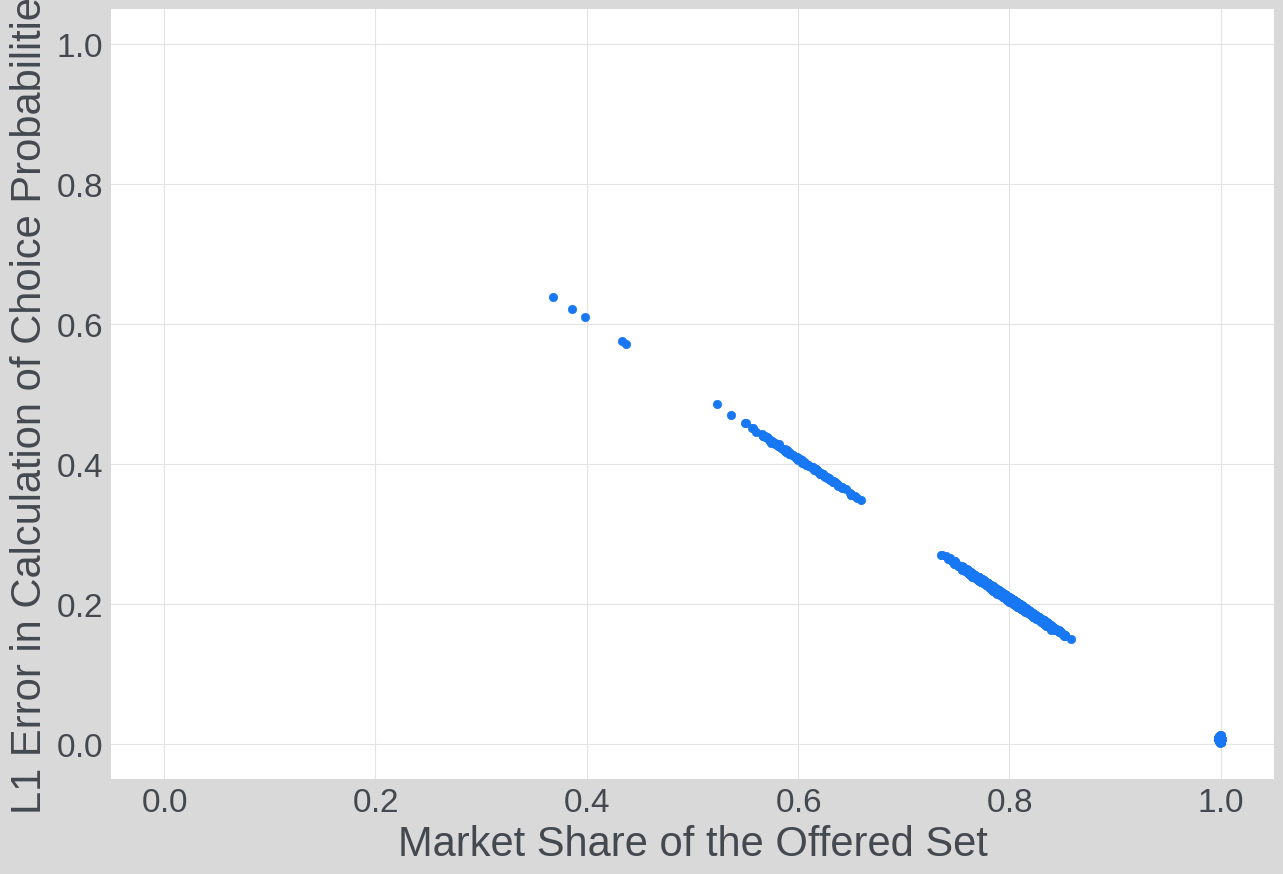

In [24]:
if True:
    x, y = generate_x_y(
        experiment_parameters=experiment_parameters_scatter_plot,
        num_runs=10 * 1000,
        set_size_to_analyze=4,
    )

    plt.xlabel("Market Share of the Offered Set", fontsize=label_fontsize)
    plt.ylabel("L1 Error in Calculation of Choice Probabilities", fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.xlim(0.0 - x_y_lim_eps, 1.0 + x_y_lim_eps)
    plt.ylim(0.0 - x_y_lim_eps, 1.0 + x_y_lim_eps)
    plt.scatter(x, y)

In [25]:
experiment_parameters_scatter_plot = ExperimentParameters(
    num_elements=16,
    num_layers_with_element_in_dag=8,
    rho=0.05
)

print("Experiment Parameters:")
for label in experiment_parameters_scatter_plot.__dict__:
    print("\t>> ", label, ": ", experiment_parameters_scatter_plot.__dict__[label], sep="")

Experiment Parameters:
	>> num_elements: 16
	>> num_frequent_permutations: 5
	>> num_rare_permutations: 20
	>> rho: 0.05
	>> cv: 0.1
	>> num_layers_with_element_in_dag: 8
	>> kappa: 0.01
	>> delta: 0.05
	>> eps: 0.001


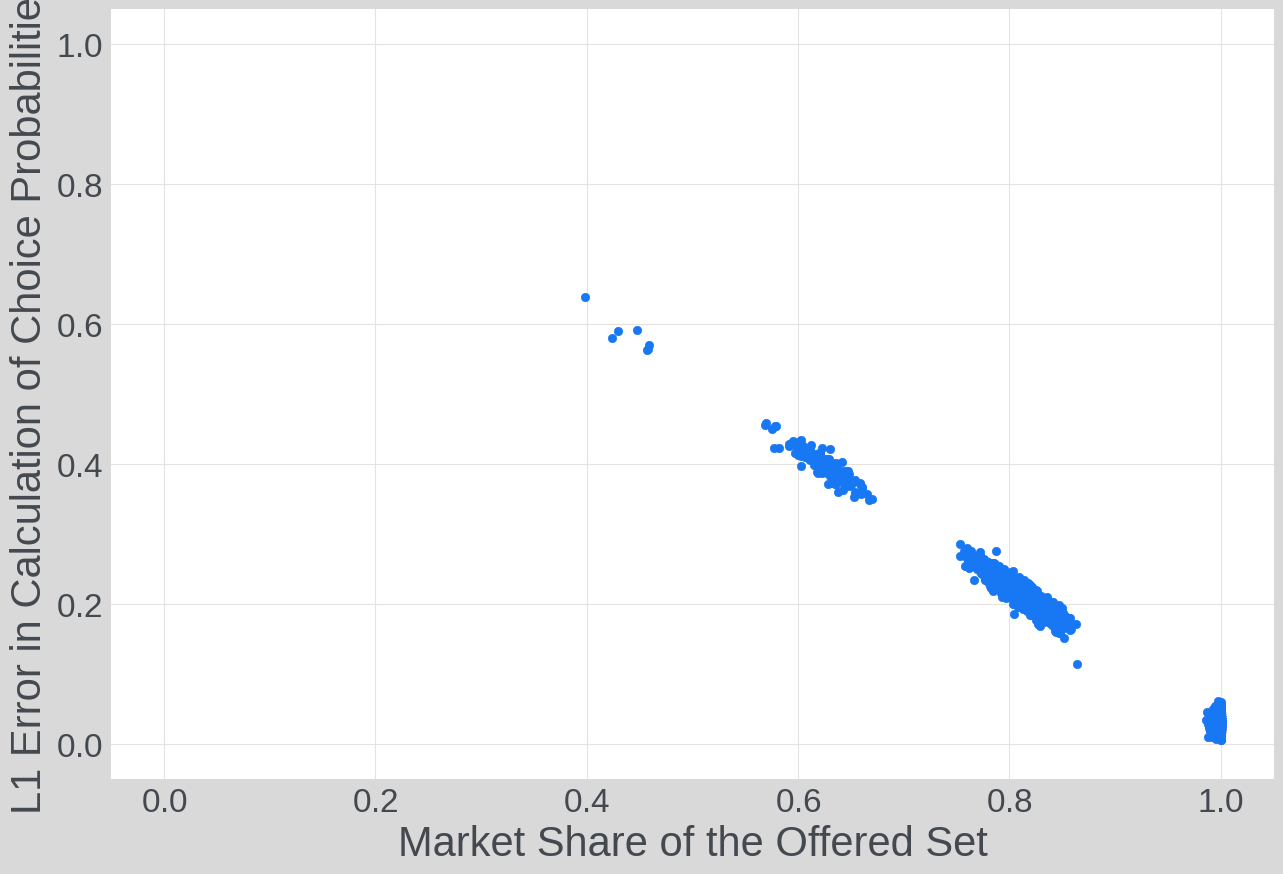

In [26]:
if True:
    x, y = generate_x_y(
        experiment_parameters=experiment_parameters_scatter_plot,
        num_runs=10 * 1000,
        set_size_to_analyze=4,
    )

    plt.xlabel("Market Share of the Offered Set", fontsize=label_fontsize)
    plt.ylabel("L1 Error in Calculation of Choice Probabilities", fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.xlim(0.0 - x_y_lim_eps, 1.0 + x_y_lim_eps)
    plt.ylim(0.0 - x_y_lim_eps, 1.0 + x_y_lim_eps)
    plt.scatter(x, y)

# Changing Epsilon

In [27]:
experiment_parameters_scatter_plot = ExperimentParameters(
    num_elements=16,
    num_layers_with_element_in_dag=8,
    eps=0.05
)

print("Experiment Parameters:")
for label in experiment_parameters_scatter_plot.__dict__:
    print("\t>> ", label, ": ", experiment_parameters_scatter_plot.__dict__[label], sep="")

Experiment Parameters:
	>> num_elements: 16
	>> num_frequent_permutations: 5
	>> num_rare_permutations: 20
	>> rho: 0.01
	>> cv: 0.1
	>> num_layers_with_element_in_dag: 8
	>> kappa: 0.01
	>> delta: 0.05
	>> eps: 0.05


In [28]:
if False:
    x, y = generate_x_y(
        experiment_parameters=experiment_parameters_scatter_plot,
        num_runs=10,
        set_size_to_analyze=4,
    )

    plt.xlabel("Market Share of the Offered Set", fontsize=label_fontsize)
    plt.ylabel("L1 Error in Calculation of Choice Probabilities", fontsize=label_fontsize)
    plt.scatter(x, y)